## **Load *Monod*+meK-Means and Packages**

In [1]:
import sys
sys.path.insert(0, '/home/tchari/monod/src/')

In [2]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis, mminference

In [3]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import scipy.stats

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.metrics import accuracy_score, classification_report

import os

import sklearn

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## **Load Metadata and Select Genes for Inference Across Conditions**

In [5]:
#Test with controls for now, and remove later if necessary 

In [6]:
meta_path = "/home/tchari/metadata/"
meta = pd.read_csv(meta_path+'norman_GSE133344_filtered_cell_identities.csv')
meta.head()

cell_barcode                    guide_identity  read_count  \
0  TTGAACGAGACTCGGA-2  ARID1A_NegCtrl0__ARID1A_NegCtrl0       28684   
1  CGTTGGGGTGTTTGTG-7  BCORL1_NegCtrl0__BCORL1_NegCtrl0       18367   
2  GAACCTAAGTGTTAGA-6      FOSB_NegCtrl0__FOSB_NegCtrl0       16296   
3  CCTTCCCTCCGTCATC-4                SET_KLF1__SET_KLF1       16262   
4  TCAATCTGTCTTTCAT-2      OSR2_NegCtrl0__OSR2_NegCtrl0       16057   

   UMI_count   coverage  gemgroup  good_coverage  number_of_cells  
0       1809  15.856274         2           True                1  
1        896  20.498884         7           True                1  
2        664  24.542169         6           True                1  
3        850  19.131765         4           True                1  
4       1067  15.048735         2           True                2

In [7]:
ids = list(meta['guide_identity'].value_counts().index)
counts = list(meta['guide_identity'].value_counts())

saveCounts = pd.DataFrame()
saveCounts['guide_identity'] = ids
saveCounts['cells'] = counts
saveCounts.head()

guide_identity  cells
0  NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0   3532
1    NegCtrl1_NegCtrl0__NegCtrl1_NegCtrl0   2948
2  NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0   2839
3    NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0   2536
4            CEBPE_RUNX1T1__CEBPE_RUNX1T1   1219

Filter for conditions with > 100 cells (since we're looking for possible subpopulations/states etc)

In [8]:
ctrls = ['NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0','NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0',
          'NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0']

ctrl_bars = list(meta.cell_barcode[meta.guide_identity.isin(ctrls)])


filt_ids = list(saveCounts['guide_identity'][(saveCounts['cells'] >  100)])
#list(saveCounts['guide_identity'][(saveCounts['cells'] >  100) & ~saveCounts['guide_identity'].isin(ctrls)])
len(filt_ids)

273

**For all pair conditions, find matching single conds and extract important genes**

In [9]:
import random

In [10]:
def input_for_sel(S1,S2,SC):
    '''
    Take in S counts for cond11,2,and control
    Normalize/scale S counts for test/train data for classifier
    Output normalized data (only for cond1/2 and control)
    '''
    
    X1 = S1 #cellxgene
    X2 = S2

    X_ctrl = SC
    
    min_size = np.min([X1.shape[0],X2.shape[0],X_ctrl.shape[0]])
    sub_inds = [] 
    for x in [X1,X2,X_ctrl]:
         sub_inds += [random.sample(range(x.shape[0]),min_size)] #Keep equal sized samples
            
    #sub_inds = random.sample(range(X_ctrl.shape[0]),X2.shape[0])
    X1 = X1[sub_inds[0],:]
    X2 = X2[sub_inds[1],:]
    X_ctrl = X_ctrl[sub_inds[2],:]

    X_conds = np.concatenate((X1,X2),axis=0) #X_both


    Y_conds = ['Cond1']*X1.shape[0]+['Cond2']*X2.shape[0] #+[dataset_names[inds[2]]]*X_both.shape[0]
    Y_conds_ctrl = Y_conds + ['Ctrl']*X_ctrl.shape[0]

    Y_conds = np.array(Y_conds)
    Y_conds_ctrl = np.array(Y_conds_ctrl)

    #dataset_names[i]

    #Scale cell reads, * median_reads/reads
    condTot = np.sum(X_conds,axis=1)
    median = np.median(condTot)
    ctrlTot = np.sum(X_ctrl,axis=1)
    facts = median/condTot
    factsCtrl = median/ctrlTot


    X_conds_norm = X_conds*np.repeat(facts.reshape(-1, 1), X_conds.shape[1], 1)
    X_ctrl_norm = X_ctrl*np.repeat(factsCtrl.reshape(-1, 1), X_ctrl.shape[1], 1)

    #Scale controls to same median
    X_conds_ctrl_norm = np.concatenate((X_conds_norm,X_ctrl_norm),axis=0)

    #From each cond, subtract ctrl mean and /std dev (Z-normalization)
    ctrl_mu = np.mean(X_ctrl_norm,axis=0) #For each gene
    ctrl_std = np.std(X_ctrl_norm,axis=0)


    X_conds_norm = (X_conds_norm-ctrl_mu)/(ctrl_std+1e-4) #Can lead to divide by zeros
    X_conds_ctrl_norm = (X_conds_ctrl_norm-ctrl_mu)/(ctrl_std+1e-4)
    
    return X_conds_ctrl_norm, Y_conds_ctrl


In [11]:
def sel_genes(X_conds_ctrl_norm ,Y_conds_ctrl,g_names_2, test_size=0.2,n_jobs = 10,num_features = 100):
    '''
    Take in scaled counts for cond1/2, & control,.
    Split data into test/train for classifier and extract top predictive genes.
    Output top genes for prediction condition label.
    '''
    
    test_size = test_size
    n_jobs = n_jobs

    X = X_conds_ctrl_norm 
    Y = Y_conds_ctrl

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42, stratify=Y)

    #From https://github.com/thomasmaxwellnorman/Perturbseq_GI/blob/3b25109aeb9c0c2026bd70abd50304a0ad4e5395/perturbseq/differential_expression.py#L213
    f_repr = 100
    # n_feat * 2 because the training matrix is extended with n shadow features
    multi = ((X_train.shape[1] * 2) / (np.sqrt(X_train.shape[1] * 2) * 10))
    n_estimators = int(multi * f_repr)
    #print('n_estimators: ',n_estimators)

    #.fit()
    clf_tree = ExtraTreesClassifier(n_jobs=n_jobs, n_estimators=n_estimators, class_weight='balanced', random_state=42)
    clf_tree.fit(X_train, Y_train)

    #.predict() on X_test
    Y_pred = clf_tree.predict(X_test)

    #get accuracy_score and classification_report
    acc = accuracy_score(Y_test, Y_pred)
    print('Feature prediction accuracy (test size: {1:.1f}%): {0}\n'.format(acc, 100*test_size))
    
    print('Unpredicted labels: ', set(Y_test) - set(Y_pred))
   
    
    report = classification_report(Y_test, Y_pred)
    #print(report)


    #get feature_importances
    num_features = num_features #Top 100 genes for now

    idx = np.argsort(clf_tree.feature_importances_)[::-1]
    gene_indices = idx[0:num_features]
    top_gene_names = g_names_2[gene_indices] 
    
    plt.scatter(range(len(idx)),clf_tree.feature_importances_[idx])
    plt.vlines(f_repr,np.min(clf_tree.feature_importances_[idx]),np.max(clf_tree.feature_importances_[idx]))
    
    return top_gene_names


In [12]:
#Not 'Neg' paired conds
notNeg = [f for f in filt_ids if 'Neg' not in f]

In [13]:
first = [i.split('_')[0] for i in notNeg]
secnd = [i.split('_')[1] for i in notNeg]

all_targets = np.unique(first+secnd)

In [14]:
#Get full count matrices and barcodes
ds = lp.connect('/home/tchari/counts/norman_crispr/loom/allcrispr.loom')
U = ds.layers['unspliced'][:].T
S = ds.layers['spliced'][:].T
bars = ds.ca['barcode']
g_names = ds.ra['gene_name']
ds.close()

In [15]:
S.shape

(116844, 36601)

In [16]:
#Select genes to begin with that have enough U/S counts
filt_param={
        "min_U_mean": 0.01,
        "min_S_mean": 0.01,
        "max_U_max": 400,
        "max_S_max": 400,
        "min_U_max": 3,
        "min_S_max": 3,
    }

expr_filt = monod.preprocess.threshold_by_expression(S.T,U.T,filt_param)

In [17]:
annots=pd.read_csv('/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3',delim_whitespace=True,header=None)
print(annots.head())

filt_markers = [m for m in g_names[expr_filt] if m in list(annots[0])]
len(filt_markers)

       0      1    2   3   4   5   6   7   8   9   ...  39  40  41  42  43  \
0    TNMD  14950   48  23  10   5   2   2   2   2  ...   0   0   0   0   0   
1    DPM1  23689   98  38  25  17  10   6   5   5  ...   0   0   0   0   0   
2   SCYL3  44637  132  51  20  13   9   7   6   4  ...   0   0   0   0   0   
3  TSPAN6  12884   43  18  13   8   3   2   2   1  ...   0   0   0   0   0   
4     FGR  23122   41  18   8   4   1   1   1   1  ...   0   0   0   0   0   

   44  45  46  47  48  
0   0   0   0   0   0  
1   0   0   0   0   0  
2   0   0   0   0   0  
3   0   0   0   0   0  
4   0   0   0   0   0  

[5 rows x 49 columns]


5757

In [18]:
#Get boolean filter for genes which are also in annotation file
expr_filt = pd.Categorical(g_names).isin(filt_markers)

In [19]:
g_names_2 = g_names[expr_filt]

In [53]:
np.sum(expr_filt)

5757

In [21]:
#Filter for control condition cells
ctrl_S = S[np.isin(bars,ctrl_bars),:]

In [22]:
#Filter control cells for selected genes
ctrl_S = ctrl_S[:,expr_filt] 
ctrl_S.shape

(8907, 5757)

0
Feature prediction accuracy (test size: 20.0%): 0.6730769230769231

Unpredicted labels:  set()
1
Feature prediction accuracy (test size: 20.0%): 0.6980676328502415

Unpredicted labels:  set()
2
Feature prediction accuracy (test size: 20.0%): 0.775599128540305

Unpredicted labels:  set()
3
Feature prediction accuracy (test size: 20.0%): 0.7159468438538206

Unpredicted labels:  set()
4
Feature prediction accuracy (test size: 20.0%): 0.7904328018223234

Unpredicted labels:  set()
5
Feature prediction accuracy (test size: 20.0%): 0.8260135135135135

Unpredicted labels:  set()
6
Feature prediction accuracy (test size: 20.0%): 0.8074324324324325

Unpredicted labels:  set()
7
Feature prediction accuracy (test size: 20.0%): 0.5377777777777778

Unpredicted labels:  set()
8
Feature prediction accuracy (test size: 20.0%): 0.5185185185185185

Unpredicted labels:  set()
9
Feature prediction accuracy (test size: 20.0%): 0.7099236641221374

Unpredicted labels:  set()
10
Feature prediction accuracy 

85
Feature prediction accuracy (test size: 20.0%): 0.6564102564102564

Unpredicted labels:  set()
86
Feature prediction accuracy (test size: 20.0%): 0.5418060200668896

Unpredicted labels:  set()
87
Feature prediction accuracy (test size: 20.0%): 0.7810945273631841

Unpredicted labels:  set()
88
Feature prediction accuracy (test size: 20.0%): 0.7647058823529411

Unpredicted labels:  set()
89
Feature prediction accuracy (test size: 20.0%): 0.6111111111111112

Unpredicted labels:  set()
90
Feature prediction accuracy (test size: 20.0%): 0.5016835016835017

Unpredicted labels:  set()
91
Feature prediction accuracy (test size: 20.0%): 0.7679180887372014

Unpredicted labels:  set()
92
Feature prediction accuracy (test size: 20.0%): 0.5249406175771971

Unpredicted labels:  set()
93
Feature prediction accuracy (test size: 20.0%): 0.5816326530612245

Unpredicted labels:  set()
94
Feature prediction accuracy (test size: 20.0%): 0.5739795918367347

Unpredicted labels:  set()
95
Feature predictio

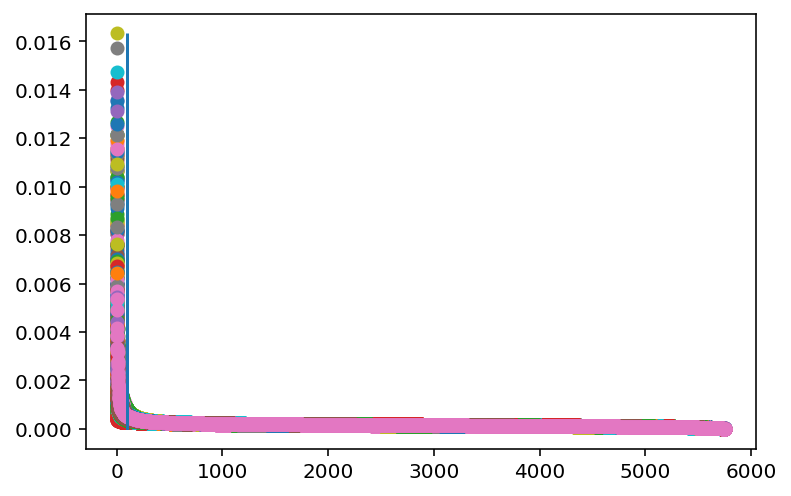

In [54]:
#Get single conds for first and secnd conds
all_gs_forinf = []
for g in range(len(first)):
    g1 = first[g]
    g2 = secnd[g]
    
    g1_nms = [f for f in filt_ids if (g1 in f and 'Neg' in f)]
    g2_nms = [f for f in filt_ids if (g2 in f and 'Neg' in f)]
    
    print(g)
    
    #sub U and S matrices
    bars1 = list(meta.cell_barcode[meta.guide_identity.isin(g1_nms)])
    bars2 = list(meta.cell_barcode[meta.guide_identity.isin(g2_nms)])
    
    if len(bars1) > 0 and len(bars2) > 0:  #May be some guides with no Neg ctrl pair in filtered list
        S1 = S[np.isin(bars,bars1),:]
        S1 = S1[:,expr_filt]
        S2 = S[np.isin(bars,bars2),:]
        S2 = S2[:,expr_filt]

        X,Y = input_for_sel(S1,S2,ctrl_S)
        imp_genes = sel_genes(X,Y,g_names_2,num_features=200)

        all_gs_forinf += list(imp_genes)
    else:
        print('no cells for '+str(g))
    

    
    
    
    

In [56]:
all_gs_forinf = np.unique(all_gs_forinf)
len(all_gs_forinf)

2623

## **Set up Files for Inference and Select Cell Barcodes**

In [25]:
ks = [10,20] #K options for meK-Means
num_ks = len(ks) #Number of Ks to try

In [26]:
#Set  up output file names for inference run results

#Make names for each of the K runs
clus_names = ['k'+str(run_k) for run_k in ks]

#Output file names
dataset_names = ['meK_norman_'+y  for y in clus_names]
print('Runs: ',dataset_names)

Runs:  ['meK_norman_k10', 'meK_norman_k20']


In [27]:
#Set reference data filepaths
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3'

#Attribute names in loom file, same as in standard kallisto|bustools --lamanno output
attribute_names=[('unspliced','spliced'),'gene_name','barcode']

loom_filepaths = ['/home/tchari/counts/norman_crispr/loom/allcrispr.loom']*num_ks #All runs use the same loom file
print('loom_filepaths: ',loom_filepaths)

n_datasets = len(loom_filepaths)

loom_filepaths:  ['/home/tchari/counts/norman_crispr/loom/allcrispr.loom', '/home/tchari/counts/norman_crispr/loom/allcrispr.loom']


Filter for barcodes in selected conditions + with UMI threshold

Dataset meK_norman_k10. 
	116844 barcodes in loom, 113389 pass filter. TTGAACGAGACTCGGA-2CGTTGGGGTGTTTGTG-7GAACCTAAGTGTTAGA-6CCTTCCCTCCGTCATC-4TCAATCTGTCTTTCAT-2TCCCGATGTCTCTTAT-8AAACCTGTCCAGAAGG-2CTGCCTAGTTCCACAA-4GAACCTATCCAGAAGG-3AAGCCGCTCACTCCTG-5TTCTTAGCATGGGAAC-7GACGGCTTCGTCACGG-1TGCGGGTCATTCACTT-8GGACAAGGTAGGGACT-5CGCGGTAGTGAGTATA-8CTGATAGTCACAGGCC-3ACGGAGACAATGGATA-5CATGGCGGTATATGAG-5ACATGGTGTCCAGTAT-5GACCAATTCAACACAC-4AACACGTCATTCTTAC-4CTAGCCTTCAACACGT-4GAACCTAAGCTCTCGG-5GCGCCAAGTGTGACCC-6CGCGGTAAGATAGTCA-1CGTTAGAGTTCGTGAT-8TGCTACCAGCGATTCT-5CGGTTAATCTTCTGGC-5AGACGTTGTCTAGCGC-2TTGGAACTCAAGCCTA-7TCAATCTCATTGAGCT-5CTAACTTCAGACGCTC-5CAACCTCAGGCGACAT-5AGACGTTGTCAAACTC-5CCAATCCAGTCAAGCG-5TACGGATTCGGATGGA-5ACGCCAGTCATCTGCC-5CAGCTGGGTTCGTTGA-4TCGGGACCAATAGCGG-1AACCATGTCTCTGAGA-5ATTATCCAGCGTGTCC-5TATCAGGCAAGCGATG-5AACCGCGCATTGGTAC-3GCGCAGTGTCCAAGTT-5TTGGAACCAGGGAGAG-7ATGCGATAGTACGCGA-5GCGCCAACACACCGCA-8AACGTTGAGCGTAGTG-1CAGCATATCTCAACTT-2TCCCGATGTAAACGCG-5ATGAGGGCATTGGCGC-2TAGGCATCACA

110125 cells in annotations. 110125 in loom. 110107 pass filter.
Dataset meK_norman_k20. 
	116844 barcodes in loom, 113389 pass filter. TTGAACGAGACTCGGA-2CGTTGGGGTGTTTGTG-7GAACCTAAGTGTTAGA-6CCTTCCCTCCGTCATC-4TCAATCTGTCTTTCAT-2TCCCGATGTCTCTTAT-8AAACCTGTCCAGAAGG-2CTGCCTAGTTCCACAA-4GAACCTATCCAGAAGG-3AAGCCGCTCACTCCTG-5TTCTTAGCATGGGAAC-7GACGGCTTCGTCACGG-1TGCGGGTCATTCACTT-8GGACAAGGTAGGGACT-5CGCGGTAGTGAGTATA-8CTGATAGTCACAGGCC-3ACGGAGACAATGGATA-5CATGGCGGTATATGAG-5ACATGGTGTCCAGTAT-5GACCAATTCAACACAC-4AACACGTCATTCTTAC-4CTAGCCTTCAACACGT-4GAACCTAAGCTCTCGG-5GCGCCAAGTGTGACCC-6CGCGGTAAGATAGTCA-1CGTTAGAGTTCGTGAT-8TGCTACCAGCGATTCT-5CGGTTAATCTTCTGGC-5AGACGTTGTCTAGCGC-2TTGGAACTCAAGCCTA-7TCAATCTCATTGAGCT-5CTAACTTCAGACGCTC-5CAACCTCAGGCGACAT-5AGACGTTGTCAAACTC-5CCAATCCAGTCAAGCG-5TACGGATTCGGATGGA-5ACGCCAGTCATCTGCC-5CAGCTGGGTTCGTTGA-4TCGGGACCAATAGCGG-1AACCATGTCTCTGAGA-5ATTATCCAGCGTGTCC-5TATCAGGCAAGCGATG-5AACCGCGCATTGGTAC-3GCGCAGTGTCCAAGTT-5TTGGAACCAGGGAGAG-7ATGCGATAGTACGCGA-5GCGCCAACACACCGCA-8AACGTTGAGCGTAGTG-1

110125 cells in annotations. 110125 in loom. 110107 pass filter.
mkdir: cannot create directory ‘./figs’: File exists


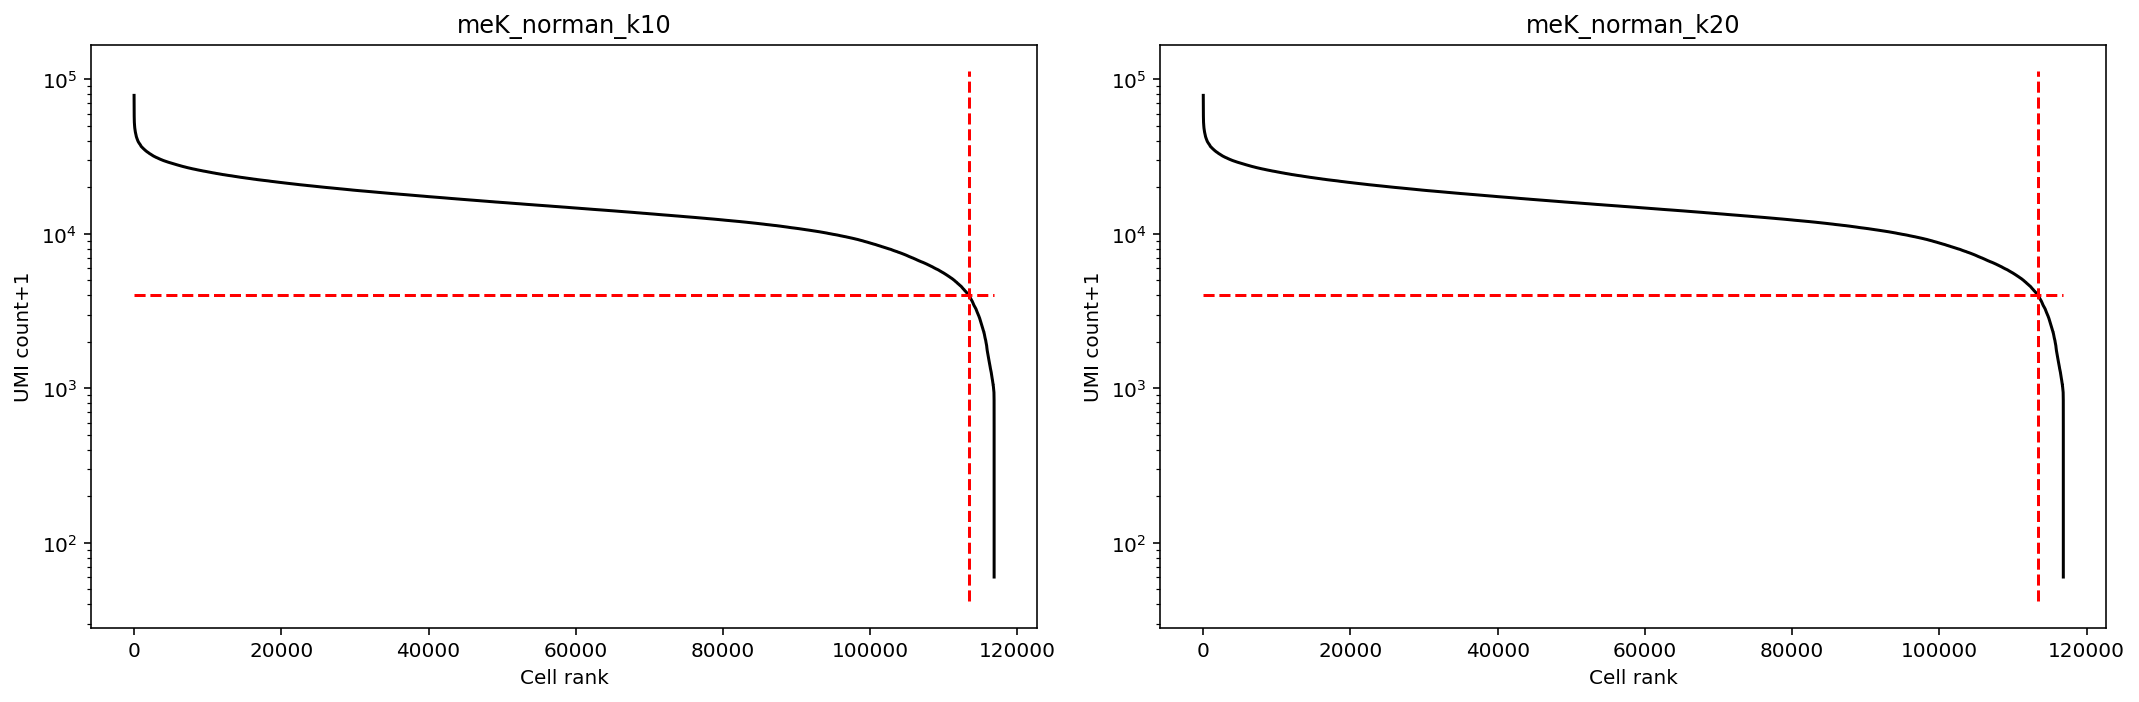

In [28]:
#Filter for cell barcodes with reasonable UMI threshold, and filter for cells in selected conditions
cf = []
thr_lb = [4e3]*num_ks #Set UMI count filter for each K run

fig1,ax1 = plt.subplots(1,num_ks,figsize=(15,5))

bcs = bars
n_cells = S.shape[0]


for k in range(num_ks):
    filename = loom_filepaths[k]
    dataset_name = dataset_names[k]


    #Make knee plot with S+U counts
    monod.preprocess.knee_plot(S.T+U.T,ax1[k],viz=True,thr=thr_lb[k])
    cf_ = ((S.T+U.T).sum(0)>thr_lb[k])

    #Make filter for low count barcodes
    n_annot_bcs = meta['cell_barcode'].sum()
    annot_bcs_in_loom = meta['cell_barcode'].isin(bcs).sum()
    annot_bcs_in_filt_loom = meta['cell_barcode'].isin(bcs[cf_]).sum()
    print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')

    #Select for barcodes in selected conditions, if applicable
    annot_bcs = meta[(meta['guide_identity'].isin(filt_ids))]['cell_barcode']
    cf.append(np.isin(bcs,annot_bcs) & cf_)
    print(f'{len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')


    ax1[k].set_title(dataset_name)

!mkdir ./figs
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_norman_meK.png'
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)

#110,107 cells

## **Create Output Files and Run meK-Means**

In [29]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [30]:
!mkdir ./fits

mkdir: cannot create directory ‘./fits’: File exists


INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230917_025_meK_norman_1 already exists.
INFO:root:Dataset: meK_norman_k10
INFO:root:110107 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 36149 were unique.
INFO:root:5748 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230917_025_meK_norman_1/meK_norman_k10 already exists.
INFO:root:Dataset: meK_norman_k20
INFO:root:110107 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 36149 were unique.
INFO:root:5748 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230917_025_meK_norman_1/meK_norman_k20 already exists.
INFO:root:Total of 2623 genes selected.
INFO:root:Directory ./fits/gg_230917_025_meK_norman_1/diagnostic_figures already exists.


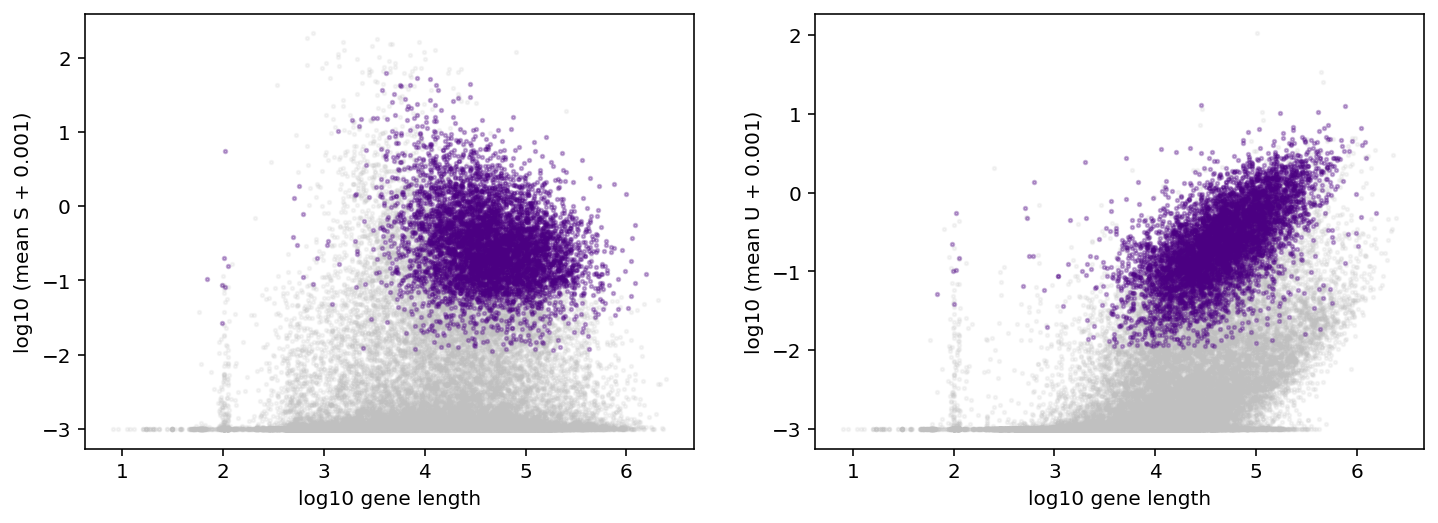

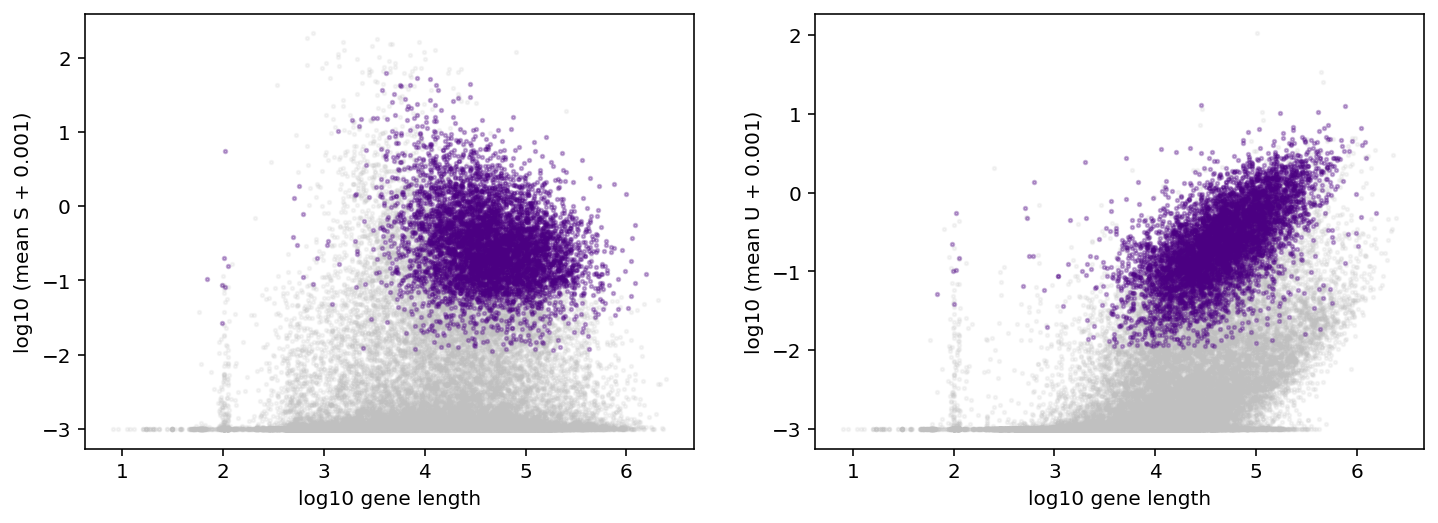

In [57]:
#Select to run inference on, same genes selected across all runs
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='meK_norman',batch_id=1,\
                                             datestring='230917', n_genes=len(all_gs_forinf),\
                                             exp_filter_threshold=None,cf=cf,
                                                             genes_to_fit=all_gs_forinf) #len(all_gs_forinf)

Save selected genes to genes.csv instead, for meK-Means

In [ ]:
# new_pd = pd.DataFrame(columns=range(len(all_gs_forinf)))
# new_pd.loc[0] = all_gs_forinf
# new_pd.to_csv('./fits/gg_230917_025_meK_norman_1/genes.csv',header=None,index=None)
# new_pd.head()

In [58]:
test = pd.read_csv('./fits/gg_230917_025_meK_norman_1/genes.csv',header=None)
test.head()

0      1       2     3      4       5      6       7     8      9     \
0  VPS13D  YIPF1  HSPB11  ENO1  CLCA1  TMEM59  RPL22  MAD2L2  MIIP  KDM5B   

   ...    2613     2614   2615   2616   2617 2618  2619    2620  2621  \
0  ...  EIF1AX  SH3KBP1  TXLNG  SYAP1  PRPS2   XG  CD99  PLCXD1  CCNQ   

        2622  
0  LINC00891  

[1 rows x 2623 columns]

**Run meK-Means**

In [59]:
#Set bounds from physical parameters search space
phys_lb = [-2.0, -1.8, -1.8 ]
phys_ub = [4.2, 2.5, 2.5]


samp_lb = [-7.157894736842105, -1.525]
samp_ub = [-7.157894736842105, -1.525]

gridsize = [1,1]

In [60]:
#Set number of epochs
epochs = 10

In [ ]:
result_strings = []
for i in range(num_ks):

    #Define model with bursty transcription and Poisson molecule capture/sampling
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    #Set up mminference parameters
    inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,k=ks[i],epochs=epochs,use_lengths = True,
                gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1})

    #Read in loom file with filtered barcodes
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[i])

    #Run inference(fit_all_grid_points()) and Save result file strings
    full_result_string = inference_parameters.fit_all_grid_points(30,search_data) 

    result_strings.append(full_result_string)
    
    

INFO:root:Directory ./fits/gg_230917_025_meK_norman_1/meK_norman_k10/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230917_025_meK_norman_1/meK_norman_k10/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: meK_norman_k10
INFO:root:36601 features observed, 36169 match genome annotations. 36149 were unique.
INFO:root:Gene list extracted from ./fits/gg_230917_025_meK_norman_1/genes.csv.
ERROR:root:Search data could not be stored to ./fits/gg_230917_025_meK_norman_1/meK_norman_k10/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [09:29<00:00, 56.92s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [09:57<00:00, 66.36s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.26807779e-02 1.06192720e-01 1.37037991e-01 1.56072798e-01
 3.44066267e-01 9.30990501e-04 2.24203701e-02 1.81159960e-01
 9.08207471e-12 3.94381259e-02]
Q Function:  -543323395.1767339

INFO:root:EM Epoch 2/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [09:41<00:00, 96.88s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.08207471e-12 1.07724809e-01 1.31711317e-01 1.47239702e-01
 3.44166799e-01 9.08207471e-12 9.08207471e-12 2.68511081e-01
 6.46291202e-04 9.08207471e-12]
Q Function:  -532110550.5582495

INFO:root:EM Epoch 3/10: 
INFO:root:Starting parallelized MLE param fits for EM.


  0%|                                                                                                                                   | 0/5 [00:00<?, ?it/s]

In [40]:
#DOes more genes --> more clusters? Try doubling to top 200?

#Read in result files for K=1,5,7 runs
sr = []
for strings in result_strings:
    sr += [[monod.analysis.load_search_results(i) for i in strings]]

sr

INFO:root:Grid scan results loaded from ./fits/gg_230917_025_meK_norman_1/meK_norman_k10/Bursty_Poisson_1x1/grid_scan_results_3.res.
INFO:root:Grid scan results loaded from ./fits/gg_230917_025_meK_norman_1/meK_norman_k10/Bursty_Poisson_1x1/grid_scan_results_4.res.
INFO:root:Grid scan results loaded from ./fits/gg_230917_025_meK_norman_1/meK_norman_k10/Bursty_Poisson_1x1/grid_scan_results_5.res.
INFO:root:Grid scan results loaded from ./fits/gg_230917_025_meK_norman_1/meK_norman_k10/Bursty_Poisson_1x1/grid_scan_results_7.res.
INFO:root:Grid scan results loaded from ./fits/gg_230917_025_meK_norman_1/meK_norman_k20/Bursty_Poisson_1x1/grid_scan_results_5.res.
INFO:root:Grid scan results loaded from ./fits/gg_230917_025_meK_norman_1/meK_norman_k20/Bursty_Poisson_1x1/grid_scan_results_6.res.
INFO:root:Grid scan results loaded from ./fits/gg_230917_025_meK_norman_1/meK_norman_k20/Bursty_Poisson_1x1/grid_scan_results_12.res.
INFO:root:Grid scan results loaded from ./fits/gg_230917_025_meK_nor

[[<monod.mminference.SearchResults at 0x7f96ab80cf10>,

In [41]:
raws = [d_string+'/raw.sd' for d_string in dataset_strings]
sd = [monod.analysis.load_search_data(w) for w in raws]
sd

INFO:root:Search data loaded from ./fits/gg_230917_025_meK_norman_1/meK_norman_k10/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230917_025_meK_norman_1/meK_norman_k20/raw.sd.


## **Assess Results of meK-Means**

In [42]:
def vis_metrics(results,title,ks,figsize=(18, 5),s=50,save_file=None):
    '''
    Visualize -Q function and KLD over epochs, and -AIC for final model inference

    results: list of len num_ks, of lists of SearchResults objs per K tested (e.g. [[SearchResults],[SearchResults,SearchResults]] for K=1&2)
    title: title string for leftmost, plot
    ks: list of ks tested (e.g. [1,2])
    figsize: tuple for size of figure
    s: size of dots in scatterplot
    save_file: string, output file to save image

  '''

    num_ks = len(results)
    sets = []
    qs = []
    res = pd.DataFrame()
    aics = pd.DataFrame()
    klds = pd.DataFrame()

    aic = []
    fin_k = []
    kls = []

    epoch = len(results[0][0].all_qs.flatten())
    epos = list(range(1,epoch+1))*num_ks

    for i in range(num_ks):

        qs += list(-1*results[i][0].all_qs.flatten())
        sets += [ks[i]]*epoch
        aic += [results[i][0].aic[0]]
        fin_k += [len(results[i])]


        concat_klds = []
        ks_used = []
        for r in results[i]:
            concat_klds += [r.all_klds[0,:,:]]
            ks_used += [r.assigns]

        concat_klds = np.array(concat_klds)
        concat_klds = concat_klds.reshape((concat_klds.shape[1], concat_klds.shape[2],concat_klds.shape[0]))

        kls += list(np.mean(np.sum(concat_klds[:,:,:],axis=1),axis=1)) #Sum of klds across k clusters


    res['Q'] = qs
    res['KLD'] = kls
    res['epoch'] = epos
    res['setting'] = ['k='+str(j) for j in sets]

    aics['AIC'] = aic
    aics['k'] = [str(j) for j in ks ]
    aics['fin_k'] = fin_k

    #Plot Q function over epochs
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)

    sns.lineplot(data=res,x='epoch',y='Q',hue='setting',
                    ax=ax[0],palette='Dark2',
                   alpha=0.7,legend=False)
    g1=sns.scatterplot(data=res,x='epoch',y='Q',hue='setting',
                    ax=ax[0],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('-Q')
    ax[0].legend(
          title='Set K')
    ax[0].set_title(title)
    sns.move_legend(g1, "upper left", bbox_to_anchor=(1, 1))


    #Plot klds over epochs
    g2=sns.lineplot(data=res,x='epoch',y='KLD',hue='setting',
                    ax=ax[1],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='KLD',hue='setting',
                    ax=ax[1],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('KLD')
    ax[1].legend(
          title='Set K')
    sns.move_legend(g2, "upper left", bbox_to_anchor=(1, 1))



    #Plot aics
    g3=sns.scatterplot(data=aics,x='fin_k',y='AIC',hue='k', ax=ax[2],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[2].set_xlabel('Final Assigned k')
    ax[2].set_ylabel('-AIC')
    ax[2].legend(
          title='Set K')
    sns.move_legend(g3, "upper left", bbox_to_anchor=(1, 1))


    plt.tight_layout()
    if save_file is None:
        plt.show()
    else:
        plt.savefig(save_file)


In [43]:
#Plot cluster concordance with true labels and distribution of clusters

def vis_assign(assign,true=None,title='',figsize=(18, 5),save_file=None):
    '''
    Plot distribution of cluster assignments (optional: with previous annotations)

    assign: np.array of cluster assignments (1..k) for each cell
    true: list of user-given cluster assignments (string) for each cell, optional
    title: title string for cluster assignment plot
    figsize: tuple for size of figure
    save_file: string, output file to save image

    '''

    true_copy = list(true)
    assign_copy = list(assign)

    #Plot cluster assignments and distribution of sizes of each cluster
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

    if true is not None:
        hues = true
    else:
        hues = assign_copy

    g= sns.histplot(x=assign,hue=hues,hue_order=list(np.unique(hues)), kde=False,ax=ax,
                    palette='tab20',multiple="dodge",
                    discrete=True)

    plt.xticks(np.arange(0,np.max(assign)+1))


    ax.set_xlabel('meK-Means Cluster Assignment')
    ax.set_title(title)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))


    plt.tight_layout()
    if save_file is None:
        plt.show()
    else:
        plt.savefig(save_file)



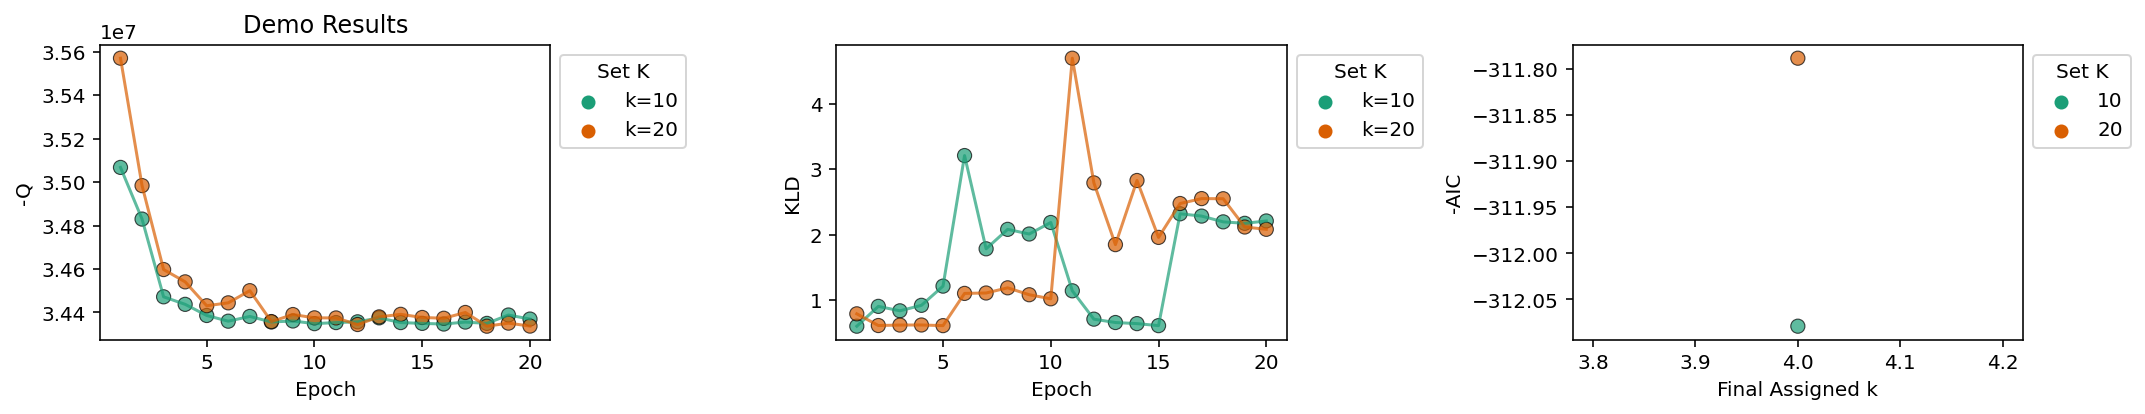

In [44]:
vis_metrics(sr,'Demo Results',ks,figsize=(15,3))

In [45]:
#Concatenate cell cluster assignments across all cells and cluster result files
mek_assigns = []
for which_res in range(len(sr)):
    k_res = sr[which_res] #Get all result files for model
    cat_assigns = np.array([None]*int(np.sum(cf[which_res]))) #cat_assigns is empty list of length = no. cell barcodes (after umi filtering)
    for i in range(len(k_res)):
        r = k_res[i]
        cat_assigns[r.filt] = r.assigns #denotes with cluster k cells were assigned to

    mek_assigns += [cat_assigns]

len(mek_assigns)

2

In [50]:
#Get 'original' cell type assignments for the filtered barcodes/cells, from Yao et al. 2021
all_assigns = [list(meta['guide_identity'][meta['cell_barcode'] == i])[0] for i in bcs[cf[0]]]
print(len(all_assigns))

110107


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


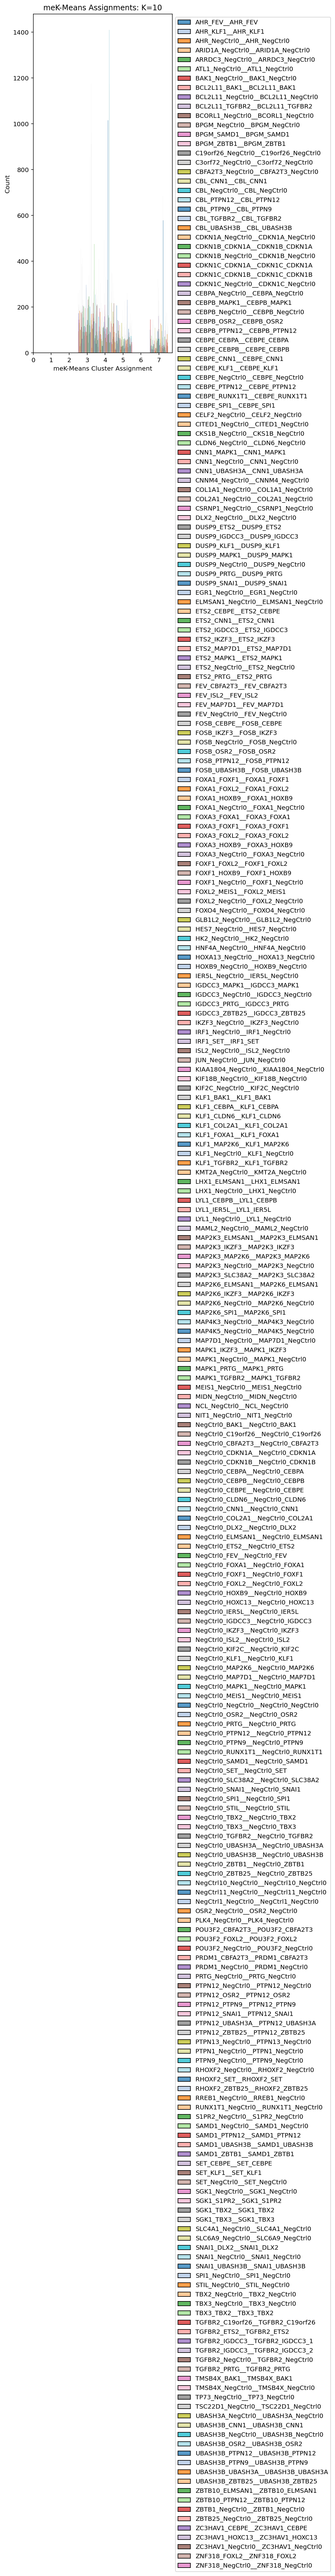

/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


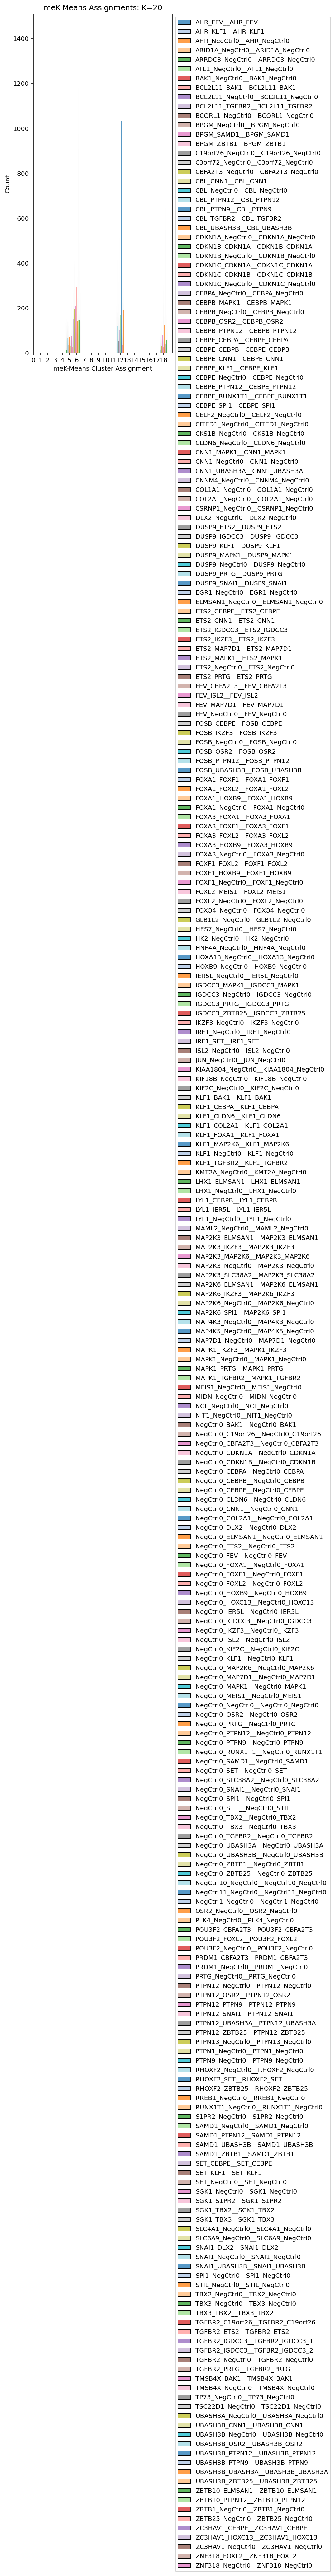

In [51]:
for i in range(len(mek_assigns)):
    m = mek_assigns[i]
    vis_assign(m,true=all_assigns,title='meK-Means Assignments: K='+str(ks[i]),figsize=(4,10))

In [136]:
filt = [('CDKN1C' in m) for m in meta['guide_identity']]
sel_bars = list(meta['cell_barcode'][filt])

In [137]:
len(sel_bars)

463

In [138]:
sel_bars += ctrl_bars

In [139]:
sub_assigns = mek_assigns[1][pd.Categorical(bcs[cf[0]]).isin(sel_bars)]

In [140]:
hues = np.array(all_assigns)[pd.Categorical(bcs[cf[0]]).isin(sel_bars)]

In [141]:
pd.Categorical(sub_assigns).value_counts()

5      685
6     3091
12    3831
18    1762
dtype: int64

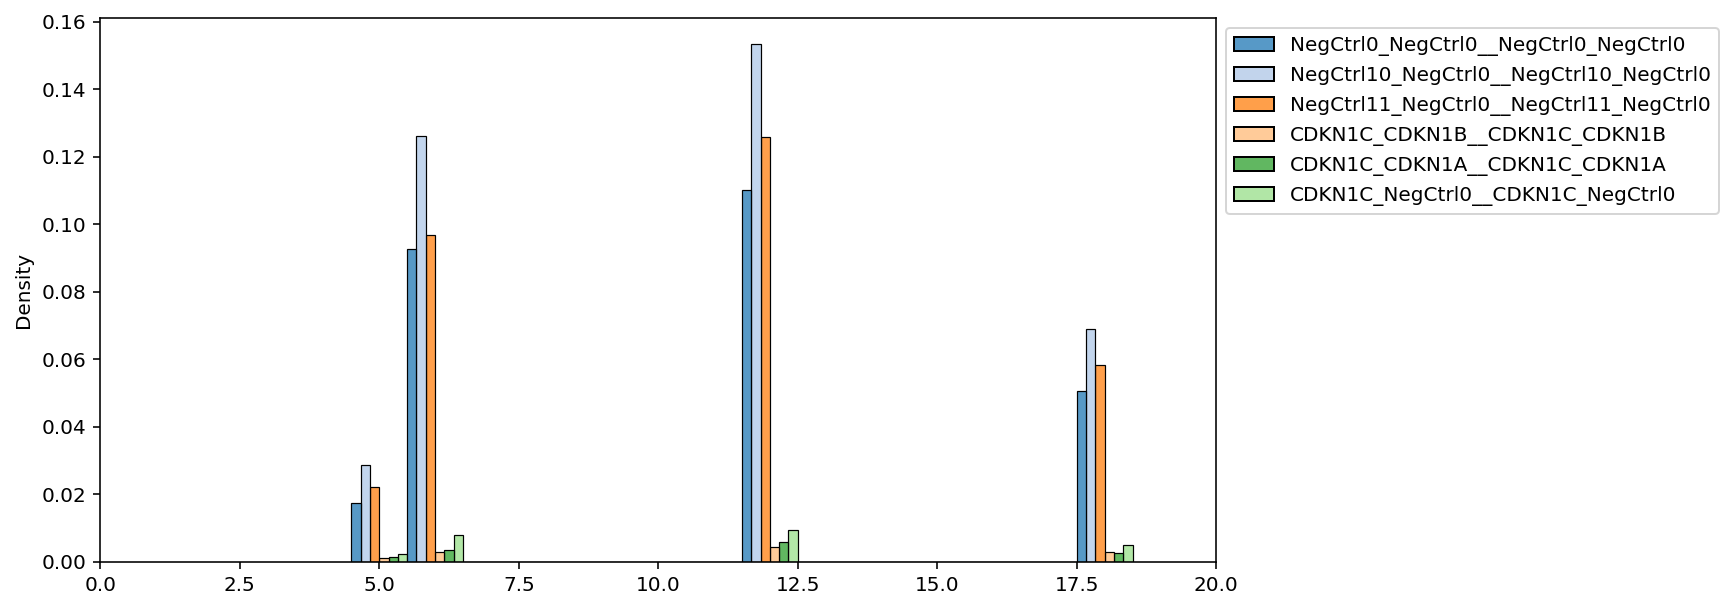

In [145]:
plt.figure(figsize=(10,5))
g=sns.histplot(x=sub_assigns,hue=hues,stat='density',multiple='dodge',palette='tab20',discrete=True)
plt.xlim(0,20)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

(array([ 2.,  5., 23., 36., 63., 43., 17.,  7.,  2.,  2.]),
 array([0.4547975 , 0.68011685, 0.9054362 , 1.13075555, 1.35607489,
        1.58139424, 1.80671359, 2.03203294, 2.25735229, 2.48267163,
        2.70799098]),
 <BarContainer object of 10 artists>)

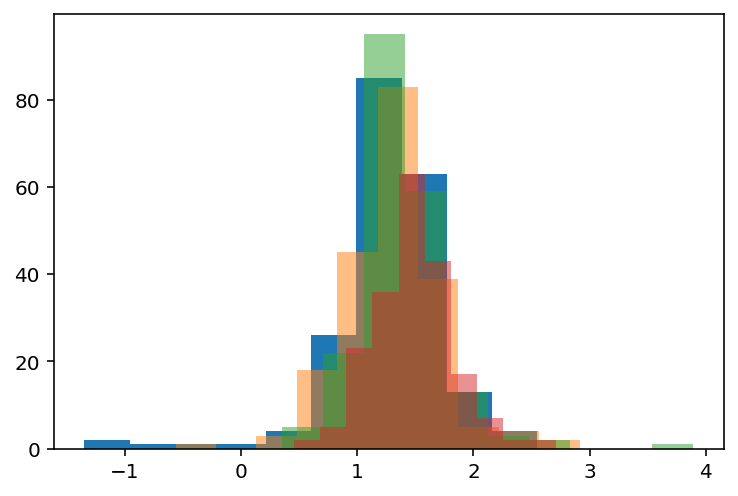

In [149]:
p=0
plt.hist(sr[1][0].param_estimates[0,:,p])
plt.hist(sr[1][1].param_estimates[0,:,p],alpha=0.5)
plt.hist(sr[1][2].param_estimates[0,:,p],alpha=0.5)
plt.hist(sr[1][3].param_estimates[0,:,p],alpha=0.5)

5802